In [5]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import animation
import json 

In [4]:
df = pd.read_csv('city.csv')
df = df.sort_values(by=['population']).tail(30)
df = df[['address', 'geo_lat', 'geo_lon']]
df = df.values.tolist()
df = [[i[0], (i[1], i[2])] for i in df]
df

[['г Кемерово', (55.391065100000006, 86.0467781)],
 ['Кемеровская область - Кузбасс, г Новокузнецк',
  (53.794315000000005, 87.2142745)],
 ['г Оренбург', (51.7875092, 55.1018828)],
 ['г Хабаровск', (48.4647258, 135.05989419999997)],
 ['г Махачкала', (42.9849159, 47.504718100000005)],
 ['г Тюмень', (57.1529744, 65.5344099)],
 ['г Иркутск', (52.2864036, 104.28074659999999)],
 ['г Ярославль', (57.62154770000001, 39.897741100000005)],
 ['г Владивосток', (43.116490399999996, 131.8823937)],
 ['г Ульяновск', (54.307941500000005, 48.3748487)],
 ['г Ижевск', (56.852738, 53.21148960000001)],
 ['г Барнаул', (53.3479968, 83.7798064)],
 ['Самарская обл, г Тольятти', (53.5205348, 49.3894028)],
 ['г Краснодар', (45.0401604, 38.975964700000006)],
 ['г Саратов', (51.533557, 46.034257000000004)],
 ['г Воронеж', (51.659333200000006, 39.1969229)],
 ['г Красноярск', (56.00938789999999, 92.85248059999999)],
 ['г Пермь', (58.0102583, 56.2342034)],
 ['г Волгоград', (48.7070042, 44.5170339)],
 ['г Уфа', (54.73

In [6]:
class SalesMan:
    def __init__(self, cities):
        self.cities = cities

    def get_next_state(self, current_state, T, energy):
        def get_new_state(current_state):
            indices = np.random.choice(len(current_state), 2, replace=False)
            new_state = np.copy(current_state)
            new_state[indices[0]] = current_state[indices[1]]
            new_state[indices[1]] = current_state[indices[0]]
            return new_state

        new_state = get_new_state(current_state)
        proposed_e = self.evaluate(new_state)
        
        if proposed_e < energy or np.exp((energy - proposed_e)/T) >= np.random.rand(1)[0]:
            return new_state
        return current_state

    def evaluate(self, path):
        length = geodesic(path[-1][1], path[0][1]).km
        for i in range(1, len(path)):
          length += geodesic(path[i-1][1], path[i][1]).km
        return length

    def simulated_annealing(self, temp, alpha):
        condidates = []
        start_time = time.time()
        evals = []
        temps = []
        iteration = 0
        condidate = self.cities
        while temp > 1:
            eval = self.evaluate(condidate)
            evals.append(eval)
            condidates.append(condidate)
            condidate = self.get_next_state(condidate, temp, eval)
            temp *= alpha
            temps.append(temp)
            iteration+=1
        return condidates, evals, temps, iteration, time.time() - start_time




Experiment with cooling rate: 0.7


/home/shamil/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


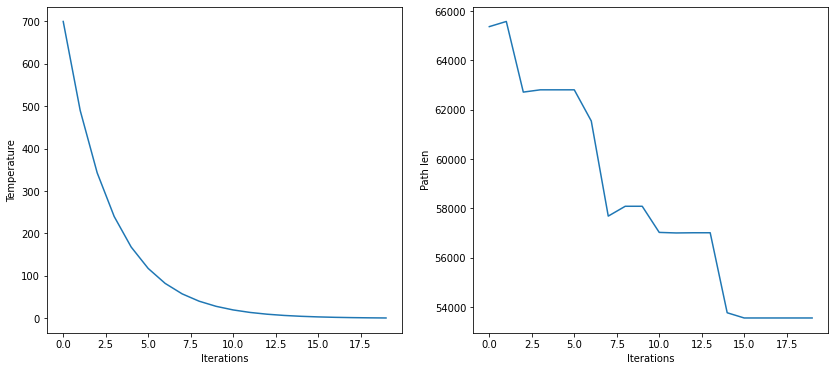

Experiment with cooling rate: 0.9


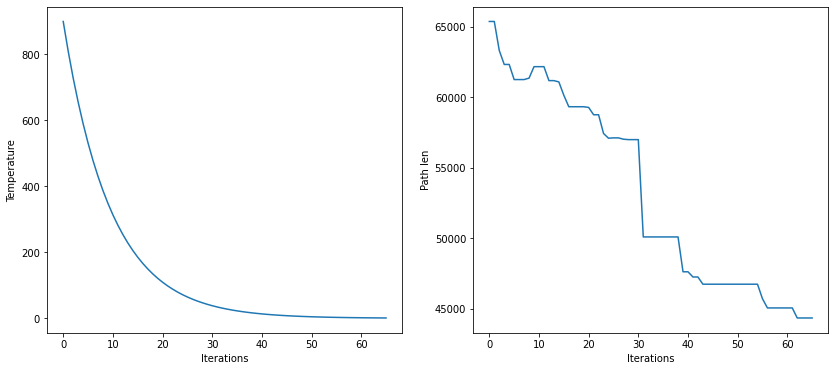

Experiment with cooling rate: 0.99


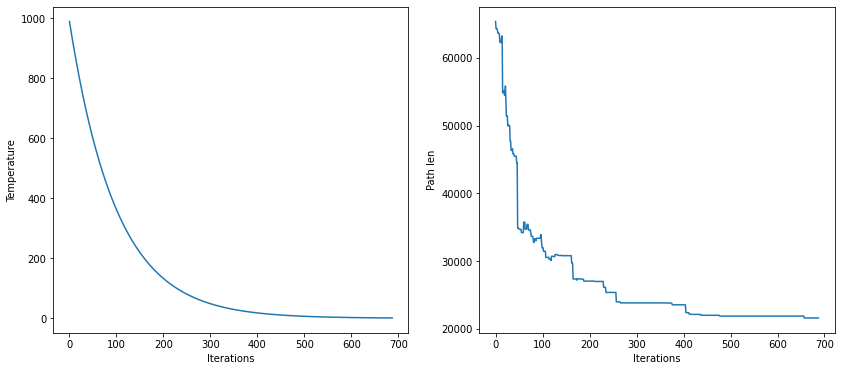

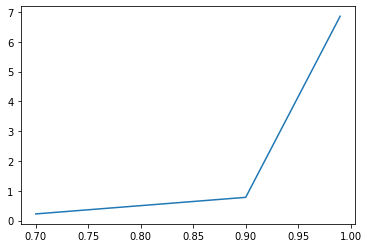

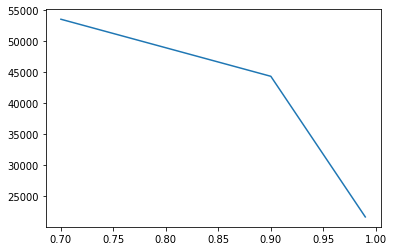

In [7]:
s = SalesMan(df)
experements = [(1000, 0.7), (1000, 0.9), (1000, 0.99)]
times = []
best = []
for e in experements:
    print(f'Experiment with cooling rate: {e[1]}')
    condidate, evals, temps, iteration, t = s.simulated_annealing(*e)
    times.append(t)
    best.append(evals[-1])
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(list(range(iteration)), temps)

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Temperature')


    ax2.plot(list(range(iteration)), evals)

    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Path len')

    plt.show()


plt.plot([i [1] for i in experements], times)
plt.show()
plt.plot([i [1] for i in experements], best)
plt.show()


/home/shamil/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


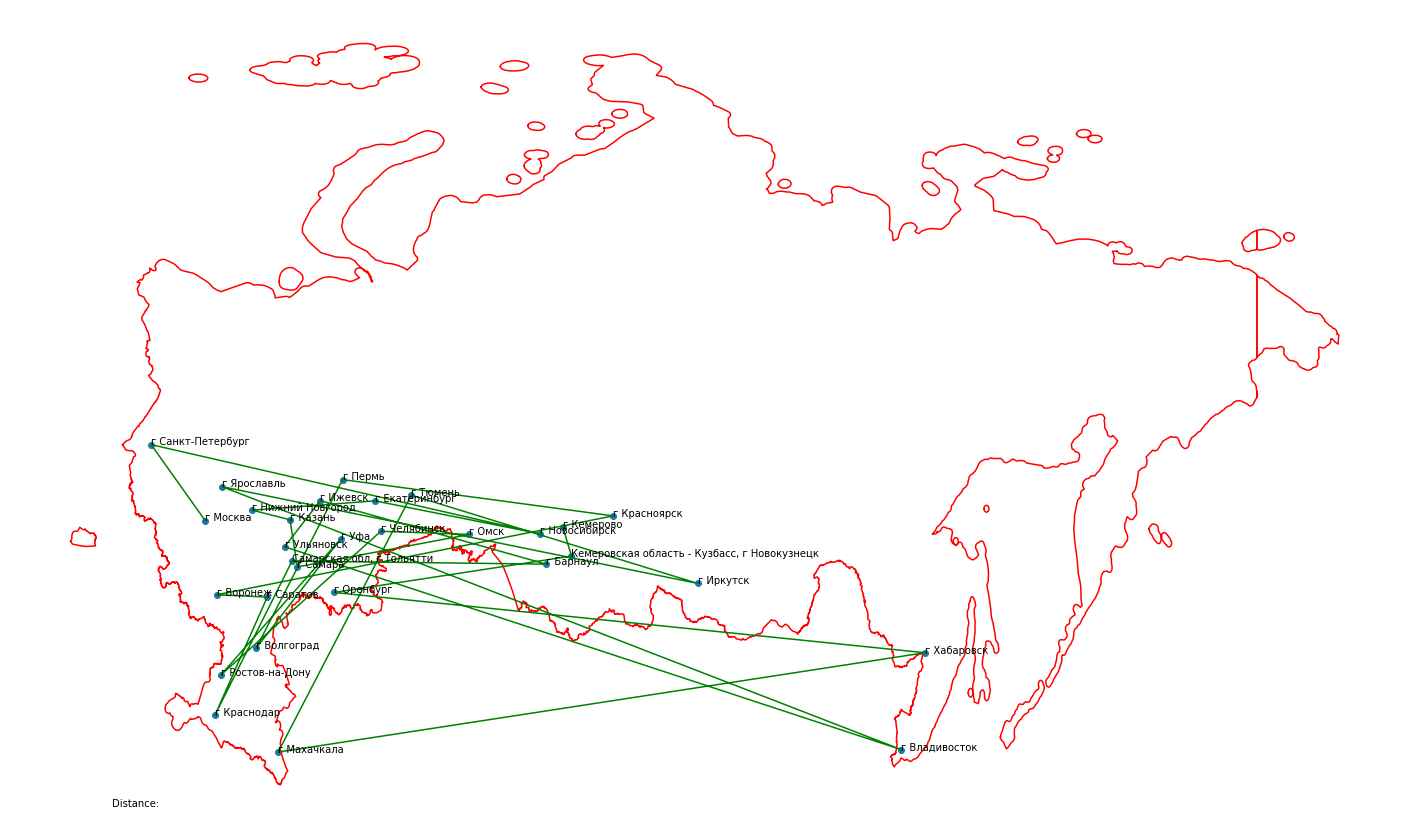

In [11]:
f = open('russia.json')
r = json.load(f)
condidate, evals, temps, iteration, t = s.simulated_annealing(1000,0.99)
r = sorted(r[0]['geojson']['coordinates'], key=lambda x: len(x))


fig, ax = plt.subplots(figsize=(25, 15))
coordinates = [c[1] for c in df]
xs, ys = tuple(map(list, zip(*coordinates)))
ax.scatter(ys, xs)


for c in df:
    ax.annotate(c[0], xy=(c[1][1], c[1][0]))

for i in r:
    c = i[0].copy()
    for cc in c:
        if cc[0]<0:
            cc[0] +=360
    x, y = zip(*c)
    ax.plot(x, y, color='r')

lines = ax.plot(ys, xs, color='g')[0]
distance = ax.text(25, 40, 'Path distance:')

def init():
     lines.set_data([], [])
     distance.set_text('')
     return lines, distance

def animate(j):
    state = condidate[j]
    coordinates = [c[1] for c in state]
    ys, xs = tuple(map(list, zip(*coordinates)))
    lines.set_data(xs, ys)
    distance.set_text(f'Path distance: {round(evals[j], 2)} km')
    return lines, distance


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(condidate)-1, interval=5, repeat=False)
plt.axis('off')
plt.show()
anim.save('animation.gif')